In [1]:
import sys; sys.path.insert(0, "..")
from src.models import NLM, LUNA
from src.utils import generate_data, neg_log_likelihood, epistemic_uncertainty

In [2]:
from autograd import numpy as np
from autograd import grad
import matplotlib.pyplot as plt

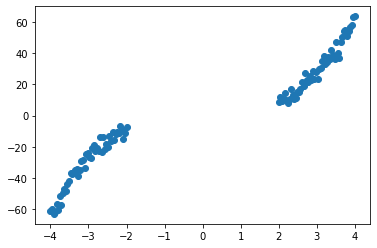

In [3]:
x, y, x_test, y_test = generate_data(number_of_points=50, noise_variance=9, 
                                     gap_start = -2, gap_end = 2, data_start = -4, data_end = 4, scale = 1)
plt.scatter(x, y)
plt.show()

In [4]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)
# activation_fn = lambda x: 1/(1+np.exp(-x))
# activation_fn = lambda x: np.exp(-x**2)

width = [50,50] # using the architecture used in the paper
hidden_layers = len(width)
input_dim = 1
output_dim = 1

architecture = {
    'width': width,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': 'relu',
    'activation_fn_params': 'rate=1',
    'activation_fn': activation_fn,
    'auxiliary_functions': 30,
}

#set random state to make the experiments replicable
rand_state = 207
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
luna = LUNA(architecture, random=random)
print('Number of parameters =',luna.D)

Number of parameters = 4180


## Inspect distribution of coSim^2 before training

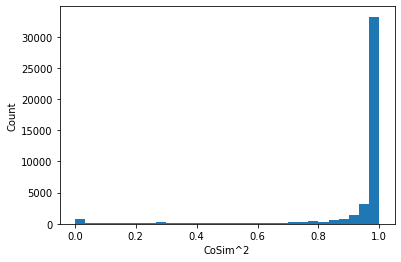

In [5]:
grad_FD = luna._finite_diff_grad(luna.weights, x.reshape(1,-1)) # M x num of samples in x_train

M = grad_FD.shape[0]
grad_angle = np.arctan(np.squeeze(grad_FD))
grad_angle_rep = np.tile(grad_angle,(M,1,1))
grad_angle_rep_transpose = np.transpose(grad_angle_rep, axes = [1,0,2]) # transpose the M x M matrix so we can take pairwise differences between auxiliary functions
coSimSqMat = np.cos(grad_angle_rep - grad_angle_rep_transpose)**2

plt.hist(coSimSqMat[np.triu(np.ones((M,M),dtype=bool),k=1)].flatten(),bins = 30);
plt.xlabel('CoSim^2')
plt.ylabel('Count');

## Inspect auxiliary functions before training

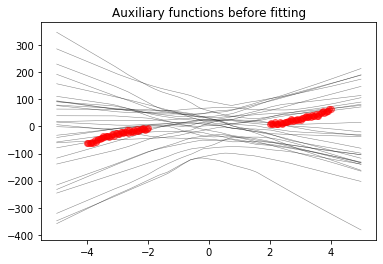

In [6]:
y_pred = luna.forward(luna.weights, x_test.reshape(1,-1))
plt.scatter(x,y,color = 'r',alpha = 0.5)
plt.plot(x_test.T, np.squeeze(y_pred).T,'k',linewidth = 0.5, alpha=0.5, zorder = 0)
plt.title('Auxiliary functions before fitting')
plt.show()

## Training LUNA

In [7]:
### define design choices in gradient descent
params = {
    'step_size':1e-2,
    'max_iteration':10000,
    'random_restarts':1,
    'reg_param':300., # 300
    'lambda_in':10000., # 10000
}

# fit LUNA
luna.fit(x, y, params)

Iteration 0 loss 22589.645685394513; gradient mag: 11500.624142770983
Iteration 100 loss 5414.312861246443; gradient mag: 1692.9490039385473
Iteration 200 loss 5295.549843816213; gradient mag: 2924.4999911868053
Iteration 300 loss 5307.121529495804; gradient mag: 9205.03216096244
Iteration 400 loss 5251.641226079348; gradient mag: 2532.778259815179
Iteration 500 loss 5263.29065817402; gradient mag: 5326.040979365954
Iteration 600 loss 5272.60070352469; gradient mag: 6853.956194425554
Iteration 700 loss 5264.989448500958; gradient mag: 5275.340554052328
Iteration 800 loss 5236.927146602104; gradient mag: 2398.5732136470597
Iteration 900 loss 5229.815068856818; gradient mag: 2463.553712220838
Iteration 1000 loss 5863.2134048188045; gradient mag: 11384.130385718536
Iteration 1100 loss 5221.367626247014; gradient mag: 878.8284883350465
Iteration 1200 loss 5231.16276953672; gradient mag: 1062.6698908983008
Iteration 1300 loss 5222.2805479865165; gradient mag: 244.05168311940236
Iteration 14

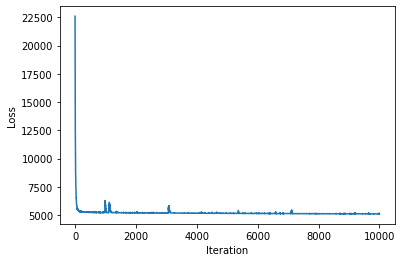

In [8]:
plt.plot(luna.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## Inspect distribution of coSim^2 after training

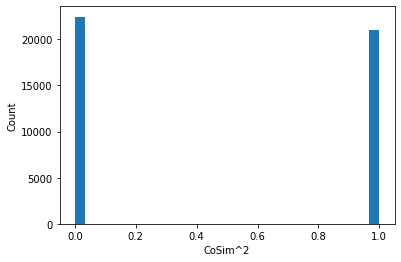

In [9]:
grad_FD = luna._finite_diff_grad(luna.weights, x.reshape(1,-1)) # M x num of samples in x_train

M = grad_FD.shape[0]
grad_angle = np.arctan(np.squeeze(grad_FD))
grad_angle_rep = np.tile(grad_angle,(M,1,1))
grad_angle_rep_transpose = np.transpose(grad_angle_rep, axes = [1,0,2]) # transpose the M x M matrix so we can take pairwise differences between auxiliary functions
coSimSqMat = np.cos(grad_angle_rep - grad_angle_rep_transpose)**2

plt.hist(coSimSqMat[np.triu(np.ones((M,M),dtype=bool),k=1)].flatten(),bins = 30);
plt.xlabel('CoSim^2')
plt.ylabel('Count')
plt.show()

## Inspect auxiliary functions after training

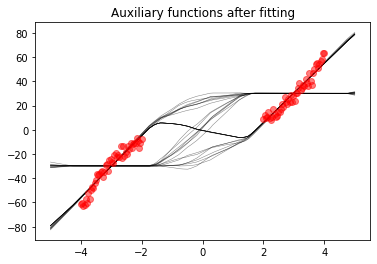

In [10]:
y_pred = luna.forward(luna.weights, x_test.reshape(1,-1))
plt.scatter(x,y,color = 'r',alpha = 0.5)
plt.plot(x_test.T, np.squeeze(y_pred).T,'k',linewidth = 0.5, alpha=0.5, zorder = 0)
plt.title('Auxiliary functions after fitting')
plt.show()

## Plot prior predictive

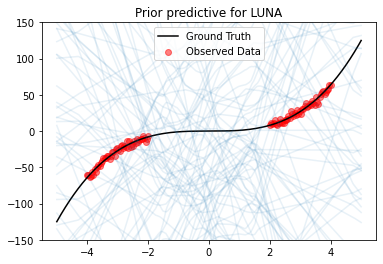

In [11]:
prior_mean = 0
prior_var = 25.
noise_var = 9.
y_prior = luna.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x[0,:], y[0,:], color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], y_test[0,:], color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.title('Prior predictive for LUNA')
plt.legend()
plt.show()

## Plot posterior predictive

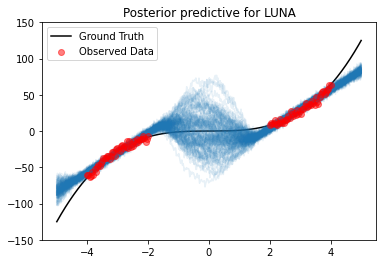

In [12]:
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)
plt.scatter(x[0,:], y[0,:], color='red', zorder = 1000, alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], y_test[0,:], color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.title('Posterior predictive for LUNA')
plt.legend()
plt.show()

In [13]:
# Calulating percentiles
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)
pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

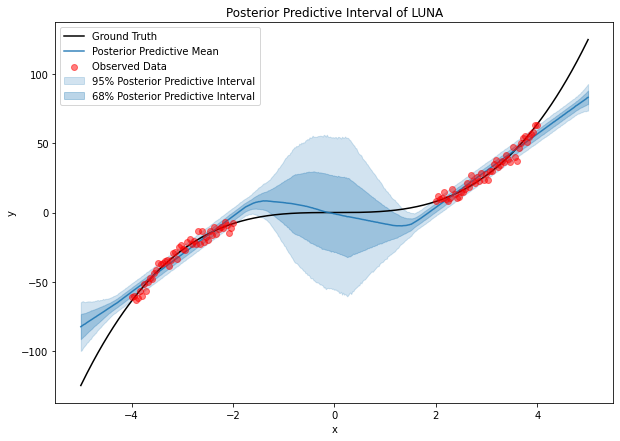

In [14]:
# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
plt.figure(figsize=(10,7))
plt.scatter(x[0,:], y[0,:], color='red', zorder = 1000, alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], y_test[0,:], color='black', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label='95% Posterior Predictive Interval')
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = '68% Posterior Predictive Interval')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of LUNA")
plt.show()

In [15]:
y_posterior = luna.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

print('Negative log likelihood on training data =', neg_log_likelihood(y_posterior, y, noise_var))
print('Epistemic uncertainty on training data = ', epistemic_uncertainty(y_posterior))


Negative log likelihood on training data = 6.615268301041023
Epistemic uncertainty on training data =  3.0616457312644965


In [16]:
# Compute neg_log_likelihood and epistemic uncertainty on test data (gap vs. non-gap)
gap_idx = np.logical_and(x_test > -2, x_test < 2)
x_test_gap = x_test[gap_idx].reshape(1,-1)
y_test_gap = y_test[gap_idx].reshape(1,-1)

non_gap_idx = np.logical_or(np.logical_and(x_test > -4, x_test < -2),np.logical_and(x_test > 2, x_test < 4))
x_test_non_gap = x_test[non_gap_idx].reshape(1,-1)
y_test_non_gap = y_test[non_gap_idx].reshape(1,-1)

y_posterior_gap = luna.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap = y_posterior_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_gap.shape)

y_posterior_non_gap = luna.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_non_gap.shape)

print('Negative log likelihood on test data (gap) =', neg_log_likelihood(y_posterior_gap, y_test_gap, noise_var))
print('Epistemic uncertainty on test data (gap) = ', epistemic_uncertainty(y_posterior_gap))

print('Negative log likelihood on test data (non-gap) =', neg_log_likelihood(y_posterior_non_gap, y_test_non_gap, noise_var))
print('Epistemic uncertainty on test data (non-gap) = ', epistemic_uncertainty(y_posterior_non_gap))

Negative log likelihood on test data (gap) = 64.47845888605869
Epistemic uncertainty on test data (gap) =  14.844019216292722
Negative log likelihood on test data (non-gap) = 4.799016923447247
Epistemic uncertainty on test data (non-gap) =  3.052800605049692


## Compare to NLM

In [17]:
# instantiate a NLM with same architecture and training parameters
nlm = NLM(architecture, random = random)

# params = {
#     'step_size':1e-2,
#     'max_iteration':2000,
#     'random_restarts':1,
#     'reg_param':300.,
# }

nlm.fit(x, y, params)

Iteration 0 loss 6221.527196115432; gradient mag: 14761.90498385506
Iteration 100 loss 252.19593798812204; gradient mag: 36.72233406907318
Iteration 200 loss 207.61473887369849; gradient mag: 9.426141381390485
Iteration 300 loss 189.78861965967047; gradient mag: 11.362319796040234
Iteration 400 loss 177.62251055951776; gradient mag: 60.11684082365293
Iteration 500 loss 167.97087689733087; gradient mag: 6.512858455060035
Iteration 600 loss 159.66639484199402; gradient mag: 6.241933351285578
Iteration 700 loss 152.33367838940737; gradient mag: 8.006633087654999
Iteration 800 loss 145.71281157829227; gradient mag: 8.729681530855743
Iteration 900 loss 139.62242620449769; gradient mag: 6.388077182385228
Iteration 1000 loss 134.03171949102645; gradient mag: 28.30114117995089
Iteration 1100 loss 128.81474469487213; gradient mag: 21.710608649686446
Iteration 1200 loss 123.9575821324628; gradient mag: 7.258491365844571
Iteration 1300 loss 119.440124964175; gradient mag: 7.521261733139256
Iterat

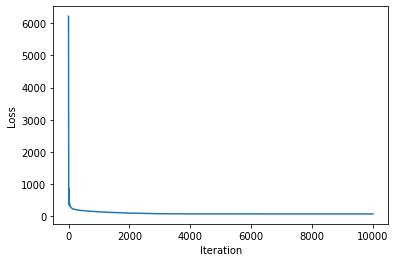

In [18]:
plt.plot(nlm.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

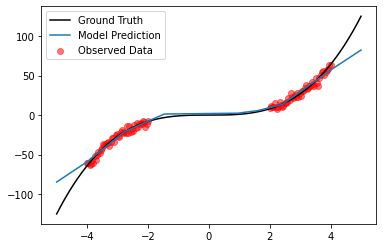

In [19]:
y_pred = nlm.forward(nlm.weights, x_test)

plt.scatter(x[0,:], y[0,:], color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], y_test[0,:], color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_pred[0,0,:], color='tab:blue', label="Model Prediction")
plt.legend()
plt.show()

## Plot prior predictive

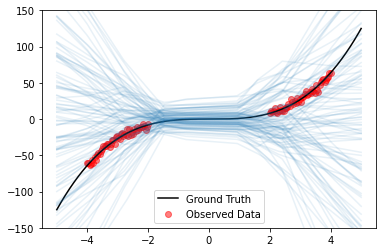

In [20]:
# prior_mean = 0
# prior_var = 9.
# noise_var = 9.
y_prior = nlm.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x[0,:], y[0,:], color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], y_test[0,:], color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.legend()
plt.show()

## Plot posterior predictive

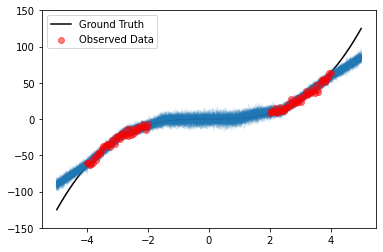

In [21]:
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)
plt.scatter(x[0,:], y[0,:], color='red', zorder = 1000, alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], y_test[0,:], color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.legend()
plt.show()

In [22]:
# Calulating percentiles
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)
pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

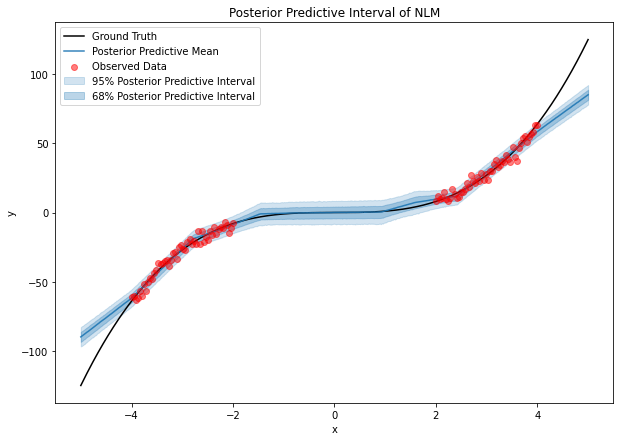

In [23]:
# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
plt.figure(figsize=(10,7))
plt.scatter(x[0,:], y[0,:], color='red', zorder = 1000, alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], y_test[0,:], color='black', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label='95% Posterior Predictive Interval')
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = '68% Posterior Predictive Interval')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of NLM")
plt.show()

In [24]:
y_posterior = nlm.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

print('Negative log likelihood on training data =', neg_log_likelihood(y_posterior, y, noise_var))
print('Epistemic uncertainty on training data = ', epistemic_uncertainty(y_posterior))



Negative log likelihood on training data = 5.354888965573567
Epistemic uncertainty on training data =  3.0818039256888916


In [25]:
# Compute neg_log_likelihood and epistemic uncertainty on test data (gap vs. non-gap)
gap_idx = np.logical_and(x_test > -2, x_test < 2)
x_test_gap = x_test[gap_idx].reshape(1,-1)
y_test_gap = y_test[gap_idx].reshape(1,-1)

non_gap_idx = np.logical_or(np.logical_and(x_test > -4, x_test < -2),np.logical_and(x_test > 2, x_test < 4))
x_test_non_gap = x_test[non_gap_idx].reshape(1,-1)
y_test_non_gap = y_test[non_gap_idx].reshape(1,-1)

y_posterior_gap = nlm.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap = y_posterior_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_gap.shape)

y_posterior_non_gap = nlm.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_non_gap.shape)

print('Negative log likelihood on test data (gap) =', neg_log_likelihood(y_posterior_gap, y_test_gap, noise_var))
print('Epistemic uncertainty on test data (gap) = ', epistemic_uncertainty(y_posterior_gap))

print('Negative log likelihood on test data (non-gap) =', neg_log_likelihood(y_posterior_non_gap, y_test_non_gap, noise_var))
print('Epistemic uncertainty on test data (non-gap) = ', epistemic_uncertainty(y_posterior_non_gap))

Negative log likelihood on test data (gap) = 5.095428533266956
Epistemic uncertainty on test data (gap) =  4.090663171387146
Negative log likelihood on test data (non-gap) = 3.9912857961949024
Epistemic uncertainty on test data (non-gap) =  3.082016265744245
